In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import time
import copy
from tqdm.auto import tqdm
from IPython.display import clear_output

In [33]:
YLIM = 3000
XLIM = 7000
G = -3.711
CRASH_PENALTY = 100000
LANDING_BONUS = 100000

In [4]:
class State:
    def __init__(self, x, y, hs, vs, fuel, rotation, power):
        self.x: float = x
        self.y: float = y
        self.hs: float = hs
        self.vs: float = vs
        self.fuel: float = fuel
        self.rotation: int = rotation
        self.power: int = power
        
    def __str__(self):
        return (f"x: {self.x}, y: {self.y}, h speed: {self.hs}, v speed: {self.vs},\n" 
            f"fuel: {self.fuel}, rotation: {self.rotation}, power: {self.power}")
            
    def next_state(self, new_rotation: int, new_power: int) -> 'State':
        if new_power < 0:
            new_power = 0
            
        elif new_power > 4:
            new_power = 4
         
        if new_rotation < -90:
            new_rotation = -90
        elif new_rotation > 90:
            new_rotation = 90
           
        
        new_power = min(self.fuel, new_power)
        new_fuel = self.fuel - new_power
        
        angle_radians = (90 - new_rotation) * math.pi / 180.0
        a_h = - new_power * math.cos(angle_radians)
        a_v = new_power * math.sin(angle_radians) + G
    
        new_x = self.x + self.hs + a_h * 0.5
        new_y = self.y + self.vs + a_v * 0.5
        
        new_hs = self.hs + a_h 
        new_vs = self.vs + a_v
        
        return State(new_x, new_y, new_hs, new_vs, new_fuel, new_rotation, new_power)
            
    def check_or_evaluate(self, last_move):
        global best
        outsideMap = self.x < 0 or self.x > 6999 or self.y < 0 or self.y > 2999
        if outsideMap:
            belowGround = False
        else:
            belowGround = self.y <= BOARD.y_vals[int(self.x)]
            
        
        # if it's not the last move of a genotype, and it's still flying safely, then return -1 
        if not last_move and not belowGround and not outsideMap:
            return 100
        
        inLandingRange = self.x > (BOARD.start_of_ground + 100) and self.x < (BOARD.end_of_ground - 100)
        
        hs_cond = abs(self.hs) < 15
        vs_cond = abs(self.vs) < 35
        
        result = 0
        if belowGround:
            if inLandingRange:
                # landed safely
                if self.rotation == 0 and abs(self.hs) < 19.5 and abs(self.vs) < 39.5:
                    #print("FOUND THE BEST!")
                    return LANDING_BONUS + self.fuel
                
                # landed with crash
                else:
                    result -= abs(self.rotation) * 10
                    if not hs_cond:
                        result -= abs(self.hs) ** 2
                    if not vs_cond:
                        result -= abs(self.vs) ** 2
                    result -= CRASH_PENALTY
                    result -= abs((BOARD.start_of_ground + BOARD.end_of_ground)/2 - self.x) * 3
                    return result
                        
            # crashed outside the landing zone
            else:
                result -= CRASH_PENALTY
        # flew over the map     
        elif outsideMap:
            result -= CRASH_PENALTY
        
        
        result -= abs(self.rotation) * 10
        if not hs_cond:
            result -= abs(self.hs) ** 2
        if not vs_cond:
            result -= abs(self.vs) ** 2
            
        # Manhattan distance to the center of the landing zone.
        result -= (abs((BOARD.start_of_ground + BOARD.end_of_ground)/2 - self.x) +
                   abs(BOARD.y_vals[BOARD.start_of_ground] - self.y)) * 10
        
        return result

In [5]:
class Board:
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
        self.__find_ground()
        self.__find_v_vals()
        
    def __find_ground(self):
        start_of_ground = -1
        length_of_ground = 0
        for i in range(1, len(self.xs)):
            if self.ys[i-1] == self.ys[i]:
                self.start_of_ground = self.xs[i-1]
                self.end_of_ground = self.xs[i]
                
    def __find_v_vals(self):
        self.y_vals = [None] * 7000
        for i in range(0, len(self.xs)-1):
            self.y_vals[self.xs[i]] = self.ys[i]
            slope = self.ys[i+1] - self.ys[i]
            n_of_points = self.xs[i+1] - self.xs[i]
            for j in range(self.xs[i] + 1, self.xs[i+1] + 1):
                if slope == 0:
                    self.y_vals[j] = self.y_vals[j-1]
                else:
                    self.y_vals[j] = self.y_vals[j-1] + (slope / n_of_points)

In [52]:
class Algorithm:
    def __init__(self, N, d, no_mutations, starting_state: State):
        self.N = N
        self.d = d
        self.no_mutations = no_mutations
        self.population = self.random_population()
        self.population_vals = np.zeros(N)
        self.current_state: State = starting_state
        self.evaluate_current_population()    
        self.first_move = True
        self.previous_move = None 
        self.bests = []
        self.means = []
    
    def random_population(self):
        return (np.stack(
            (np.random.randint(-15, 16, size = (self.N, self.d, 1)), 
             np.random.randint(-1, 2, size = (self.N, self.d, 1))), 
            axis = 3)).reshape(self.N, self.d, 2)
    
    def evaluate_population(self, population):
        return np.array([self.evaluate_individual(individual) for individual in population])
    
    def evaluate_current_population(self):
        self.simulations_positions = []
        self.population_vals = self.evaluate_population(self.population)
        
    def evaluate_individual(self, individual: np.array):
        positions = []
        state = copy.deepcopy(self.current_state)
        positions.append([state.x, state.y])
        for move in individual:
            state = state.next_state(state.rotation + move[0], state.power + move[1])
            positions.append([state.x, state.y])
            heur_val = state.check_or_evaluate(last_move = False)
            if heur_val != 100:
                self.simulations_positions.append(positions)
                return heur_val
        self.simulations_positions.append(positions)
        return state.check_or_evaluate(last_move = True)
        
    def get_parents(self):
        vals = self.population_vals - np.min(self.population_vals)
        sum_of_vals = np.sum(vals)
        if sum_of_vals == 0:
            probs = np.ones(self.N) / self.N
        else:
            probs = vals / sum_of_vals
        return self.population[
            np.random.choice(self.N, int(self.N/2), p = probs, replace = True)]
                               
    def generate_new_population(self, children, children_vals):
        all_indiv = np.vstack((children, self.population))
        all_vals = np.append(children_vals, self.population_vals)
        self.population = all_indiv[np.argsort(all_vals)][int(self.N/2):]
        self.evaluate_current_population()
    
    def mutate(self, population):
        # ith column are indices of i-th genotypes' genes that will mutate
        random_indices = np.array([np.random.choice(self.d, size=self.no_mutations, replace=False) 
                                   for _ in range(population.shape[0])]).T
        
        # population[:, :, 0] is a matrix in which i-th row describes rotations of i-th genotype
        # population[:, :, 0][np.arange..] is a matrix with shape (# of random_indices columns, self.N)
        # Every row consists of random genes to be changed. i-th element in a row is a gen from i-th genotype
        population[:, :, 0][np.arange(population.shape[0]), random_indices] = np.array(
            [np.random.randint(low = -15, high = 16, size = population.shape[0]) for _ in np.arange(self.no_mutations)])
        population[:, :, 1][np.arange(population.shape[0]), random_indices] = np.array(
            [np.random.randint(-1, 2, size = population.shape[0]) for _ in np.arange(self.no_mutations)])
        return population
        
    def do_move(self):
        best_move = self.population[np.argmax(self.population_vals)][0]
        new_rotation = best_move[0] + self.current_state.rotation
        new_power = best_move[1] + self.current_state.power
        if new_power < 0:
            new_power = 0
        elif new_power > 4:
            new_power = 4
        if new_rotation < -90:
            new_rotation = -90
        elif new_rotation > 90:
            new_rotation = 90
        self.current_state = self.current_state.next_state(self.current_state.rotation + best_move[0],
                                                           self.current_state.power + best_move[1])
        self.previous_move = np.array([new_power, new_rotation])
        
    def roll_population(self):
        self.population[:int(self.N/2)] = self.population[np.argsort(-self.population_vals)][:int(self.N/2)]
        self.population[:int(self.N/2)] = np.roll(self.population[:int(self.N/2)], -1, axis = 1)
        self.population[:int(self.N/2), self.d - 1] = np.stack(
            (np.random.randint(-15, 16, size = (int(self.N/2), 1)), 
             np.random.randint(-1, 2, size = (int(self.N/2), 1))), 
            axis = 2).reshape(int(self.N/2), 2)
        self.population[int(self.N/2):] = (np.stack(
            (np.random.randint(-15, 16, size = (int(self.N/2), self.d, 1)), 
                np.random.randint(-1, 2, size = (int(self.N/2), self.d, 1))), 
                  axis = 3)).reshape(int(self.N/2), self.d, 2)
        
        
    def do_iteration(self):
        start = timeit.default_timer()
        if self.first_move:
            time_limit = 1.0
            self.first_move = False
        else:
            time_limit = 0.1
            self.roll_population()
            self.evaluate_current_population()
        iters = 0 
        
        while(timeit.default_timer() - start < (time_limit)):
            iters += 1
            parents = copy.deepcopy(self.get_parents())
            children = self.mutate(parents)
            children_vals = self.evaluate_population(children)
            self.generate_new_population(children, children_vals)
         
        self.bests.append(np.max(self.population_vals))
        self.means.append(np.mean(self.population_vals))
        self.do_move()

In [ ]:
n = int(input())  # the number of points used to draw the surface of Mars.
xs, ys = [], []
for i in range(n):
    land_x, land_y = [int(j) for j in input().split()]
    xs.append(land_x)
    ys.append(land_y)


BOARD = Board(xs, ys)
print(xs, file = sys.stderr)
print(ys, file = sys.stderr)
R = 0
first_turn = True
# game loop
while True:
    # hs: the horizontal speed (in m/s), can be negative.
    # vs: the vertical speed (in m/s), can be negative.
    # f: the quantity of remaining fuel in liters.
    # r: the rotation angle in degrees (-90 to 90).
    # p: the thrust power (0 to 4).
    x, y, hs, vs, f, r, p = [int(i) for i in input().split()]
    if first_turn:
        STARTING_STATE = State(x, y, hs, vs, f, r, p)
        ALG = Algorithm(N = 20, d = 80, no_mutations = 6, starting_state = STARTING_STATE)
        first_turn = False
    # Write an action using print
    # To debug: print("Debug messages...", file=sys.stderr, flush=True)

    # R P. R is the desired rotation angle. P is the desired thrust power.
    ALG.do_iteration()
    print(f"{ALG.previous_move[1]} {ALG.previous_move[0]}")

## Testing:

In [8]:
XS = [0,   1000, 1500, 3000, 4000, 5500, 6999]
YS = [100, 500,  1500, 1000, 150,  150,  800]
XS2 = [0, 1000, 1500, 3000, 3500, 3700, 5000, 5800, 6000, 6999]
YS2 = [100, 500, 100, 100, 500, 200, 1500, 300, 1000, 2000]
YLIM = 3000
XLIM = 7000

In [9]:
STARTING_STATE = State(2500, 2700, 0, 0, 550, 0, 0)
BOARD = Board(XS, YS)

In [69]:
%%time
best = 0
ALG = Algorithm(N = 20, d = 80, no_mutations = 6, starting_state = STARTING_STATE)

Wall time: 15 ms


In [67]:
for i in range(80):
    ALG.do_iteration()

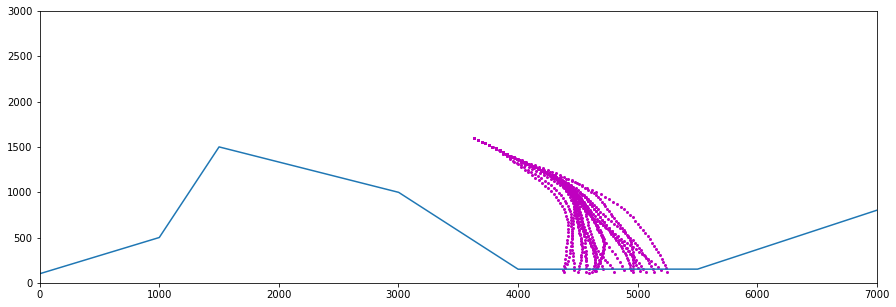

x: 3665.6687046824786, y: 1575.8655157877947, h speed: 29.89992236798742, v speed: -18.7087687302636,
fuel: 336, rotation: -1, power: 4
[-102928.87154955 -102876.57244849 -102874.27931816 -102822.61768445
 -102604.97321535 -102325.6087171  -102293.54849894 -102194.98531742
 -101945.20384392 -101472.04324759 -101055.57056648 -100819.32632563
 -100693.35461077 -100663.89772191 -100568.69471018 -100418.34755853
 -100321.91820873 -100308.03604769  100105.          100123.        ]


In [70]:
for i in range(60):
    ALG.do_iteration()
    plt.figure(figsize = (15, 5))
    plt.gca().set_xlim(0,XLIM)
    plt.gca().set_ylim(0,YLIM)
    plt.plot(np.arange(0, 7000), BOARD.y_vals)
    for index, positions in enumerate(ALG.simulations_positions):
        for x, y in positions:
            plt.scatter(x, y, s=4, c = 'm')
    clear_output(wait=True)
    plt.show()
    print(ALG.current_state)
    print(ALG.population_vals)

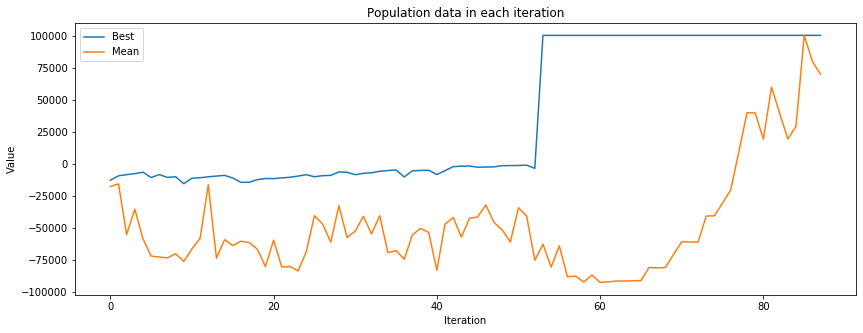

In [68]:
plt.figure(figsize=(14, 5))
plt.title(f"Population data in each iteration")
plt.plot(ALG.bests, label = "Best")
plt.plot(ALG.means, label = "Mean")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()